In [1]:
# Import packages and paths
import numpy as np, pandas as pd, matplotlib.pyplot as plt, joblib, pathlib
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LogisticRegression

BASE = pathlib.Path.cwd().parents[0]
DATA_PROCESSED = BASE / "data" / "processed"
MODELS = BASE / "models"
REPORTS = BASE / "reports"
REPORTS.mkdir(exist_ok=True)

SYMBOLS = ["QQQ", "VFV.TO", "XEQT.TO"]  # adjust as needed
TRADING_DAYS = 252

In [3]:
# Helper functions for next cells
def load_dataset(symbol: str) -> pd.DataFrame:
    df = pd.read_parquet(DATA_PROCESSED / f"{symbol}_dataset.parquet")
    return df.sort_values("date").reset_index(drop=True)

def ts_cv_indices(n_samples: int, n_splits: int = 5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    return list(tscv.split(np.arange(n_samples)))

def equity_from_logrets(r: np.ndarray, start: float = 1.0) -> np.ndarray:
    """Turn daily log returns into equity curve."""
    return start * np.exp(np.nancumsum(r))

def perf_metrics(logrets: pd.Series) -> dict:
    """Annualized metrics from daily log returns (natural log)."""
    r = logrets.dropna()
    if len(r) == 0:
        return dict(CAGR=np.nan, Vol=np.nan, Sharpe=np.nan, MaxDD=np.nan)
    # CAGR from log returns
    cagr = r.mean() * TRADING_DAYS
    vol  = r.std(ddof=0) * np.sqrt(TRADING_DAYS)
    sharpe = cagr / vol if vol > 0 else np.nan
    # Max drawdown on equity curve
    eq = equity_from_logrets(r.values)
    peak = np.maximum.accumulate(eq)
    dd = (eq - peak) / peak
    maxdd = dd.min()
    return dict(CAGR=cagr, Vol=vol, Sharpe=sharpe, MaxDD=maxdd)

In [5]:
# Walk-forward cross validation for regression and classification model
def wf_predict_reg(df: pd.DataFrame, algo: str = "ridge", n_splits: int = 5) -> pd.Series:
    """Return out-of-sample yhat for regression (aligned to df rows)."""
    X = df.drop(columns=["date","y_reg","y_cls"]).values.astype(float)
    y = df["y_reg"].values
    folds = ts_cv_indices(len(X), n_splits)
    # choose model
    if algo == "ridge":
        model = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge())])
    elif algo == "hgb":
        from sklearn.ensemble import HistGradientBoostingRegressor
        model = HistGradientBoostingRegressor()
    else:
        raise ValueError("algo must be 'ridge' or 'hgb'")
    yhat = np.full_like(y, np.nan, dtype=float)
    for tr, te in folds:
        model.fit(X[tr], y[tr])
        yhat[te] = model.predict(X[te])
    return pd.Series(yhat, index=df.index)

def wf_predict_cls(df: pd.DataFrame, n_splits: int = 5) -> pd.Series:
    """Return out-of-sample probabilities for y_cls (aligned)."""
    X = df.drop(columns=["date","y_reg","y_cls"]).values.astype(float)
    y = df["y_cls"].values
    folds = ts_cv_indices(len(X), n_splits)
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("logit", LogisticRegression(max_iter=200, class_weight="balanced")),
    ])
    proba = np.full_like(y, np.nan, dtype=float)
    for tr, te in folds:
        model.fit(X[tr], y[tr])
        proba[te] = model.predict_proba(X[te])[:,1]
    return pd.Series(proba, index=df.index)

In [6]:
# Long/cash strategy
def run_long_cash_strategy(
    df: pd.DataFrame,
    signal: pd.Series,
    kind: str = "reg",         # "reg" or "cls"
    reg_thr: float = 0.0,      # go long if yhat > reg_thr
    cls_thr: float = 0.55,     # go long if proba > cls_thr
    cost_bps: float = 0.0005   # 5 bps one-way
) -> pd.DataFrame:
    out = pd.DataFrame(index=df.index)
    out["date"] = df["date"]
    out["y_reg"] = df["y_reg"]              # next-day log return (ground truth)

    # Convert signal → position
    if kind == "reg":
        pos = (signal > reg_thr).astype(int)
    else:
        pos = (signal > cls_thr).astype(int)

    # Trading cost when position changes
    trades = pos.diff().abs().fillna(0.0)
    costs = cost_bps * trades

    # Strategy log return
    out["pos"] = pos
    out["costs"] = costs
    out["r_strategy"] = pos * out["y_reg"] - costs

    # Buy & hold (no costs)
    out["r_bh"] = out["y_reg"]

    # Equity curves
    out["equity_strategy"] = equity_from_logrets(out["r_strategy"].values, 1.0)
    out["equity_bh"] = equity_from_logrets(out["r_bh"].values, 1.0)
    return out

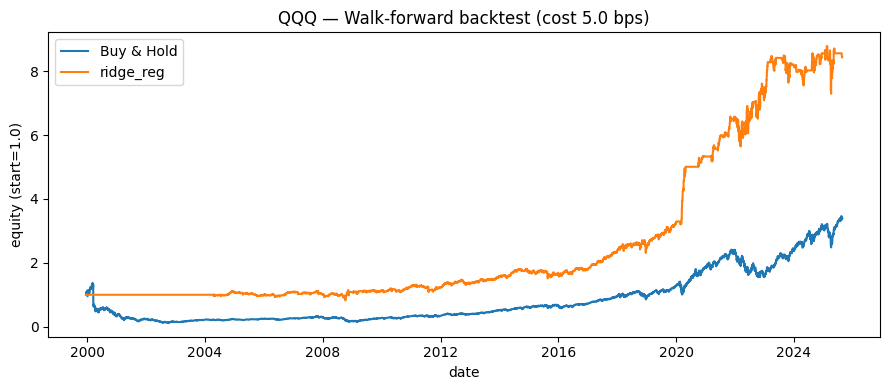

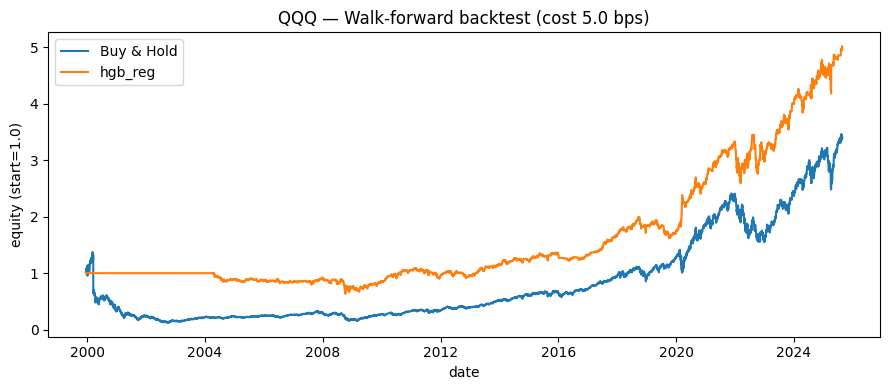

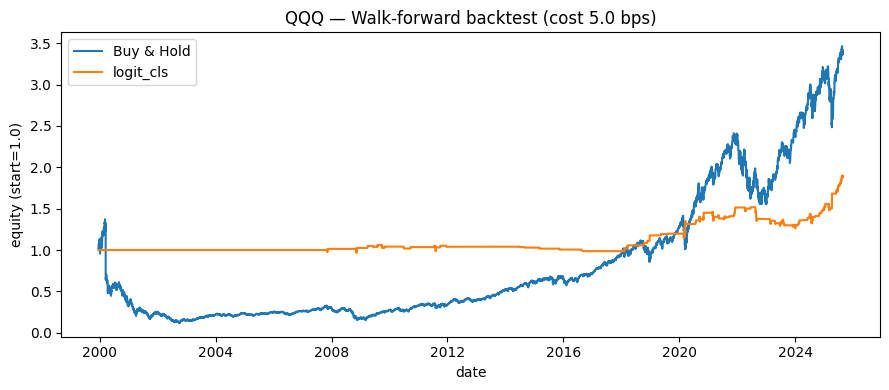

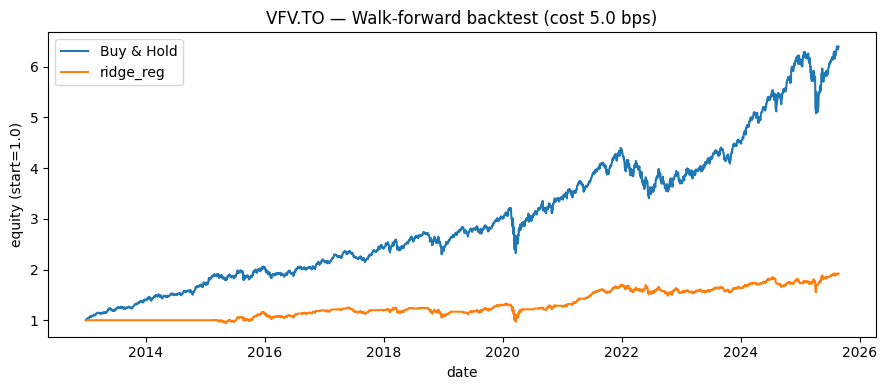

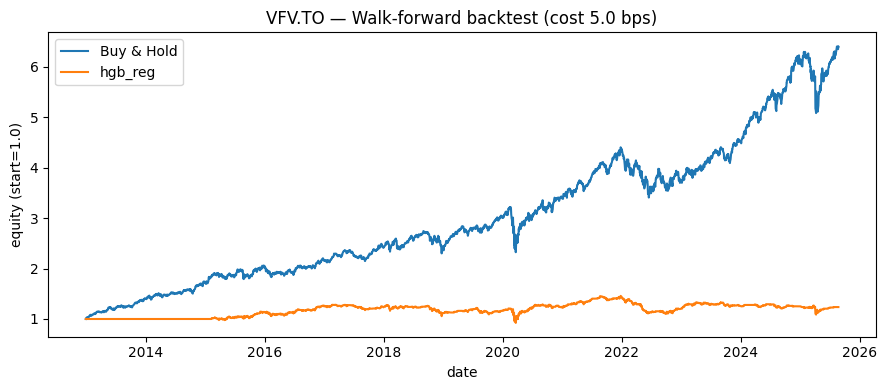

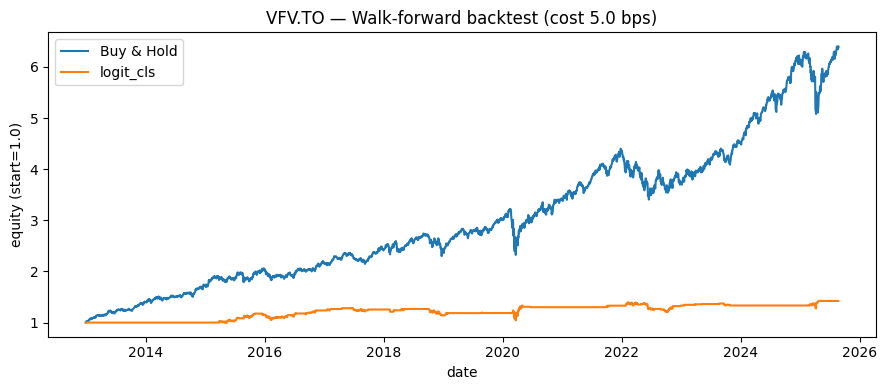

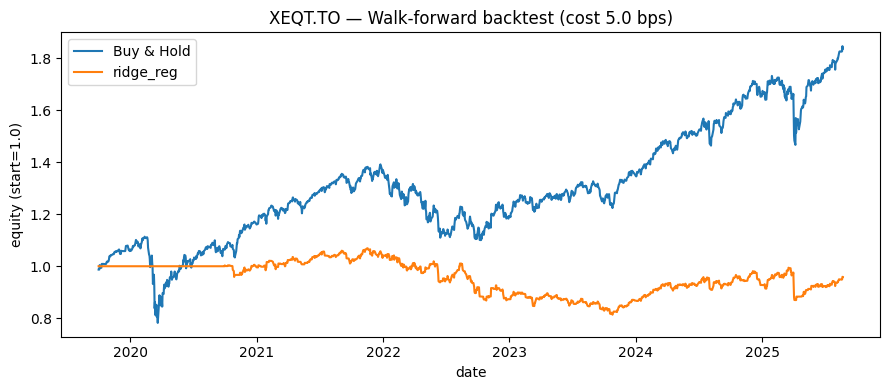

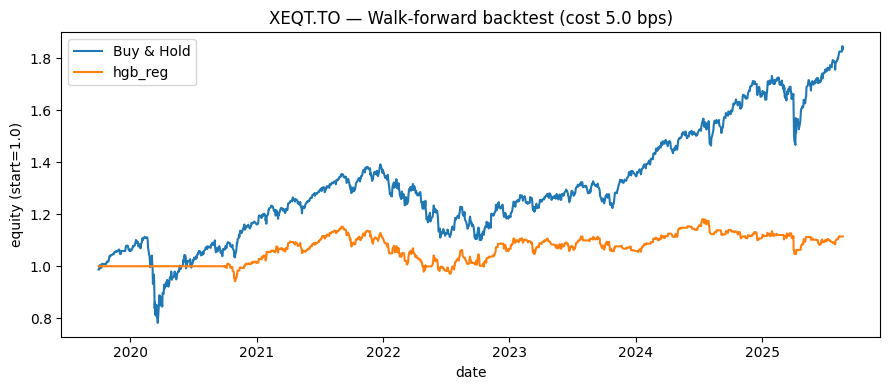

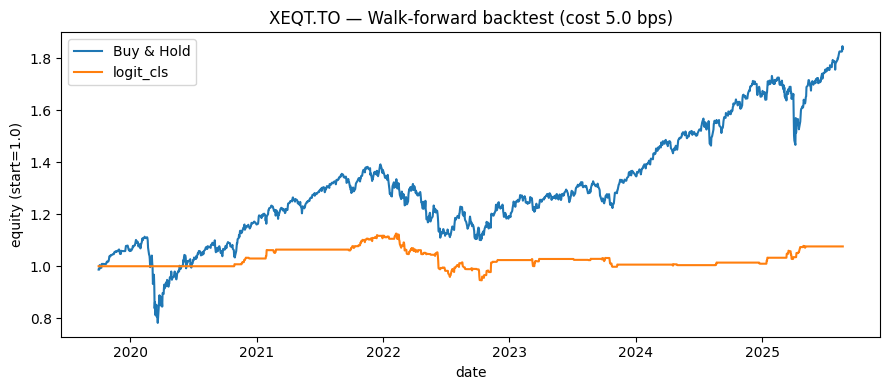

,symbol,model,CAGR,Vol,Sharpe,MaxDD,BH_CAGR,BH_Sharpe,BH_MaxDD
1,QQQ,hgb_reg,0.062821,0.131350,0.478274,-0.368049,0.047788,0.156498,-0.912783
2,QQQ,logit_cls,0.024891,0.066434,0.374669,-0.169681,0.047788,0.156498,-0.912783
0,QQQ,ridge_reg,0.083201,0.139011,0.598523,-0.264914,0.047788,0.156498,-0.912783
4,VFV.TO,hgb_reg,0.016834,0.126469,0.133104,-0.279999,0.147242,0.925384,-0.277178
5,VFV.TO,logit_cls,0.028000,0.099249,0.282123,-0.188098,0.147242,0.925384,-0.277178
3,VFV.TO,ridge_reg,0.051891,0.133089,0.389899,-0.269935,0.147242,0.925384,-0.277178
7,XEQT.TO,hgb_reg,0.018458,0.085619,0.215580,-0.157733,0.103446,0.645798,-0.297429
8,XEQT.TO,logit_cls,0.012488,0.049395,0.252813,-0.159599,0.103446,0.645798,-0.297429
6,XEQT.TO,ridge_reg,-0.007140,0.088221,-0.080938,-0.238893,0.103446,0.645798,-0.297429


Saved: /Users/itzronald/Desktop/trend-predictor/reports/day6_backtest_metrics.csv


In [8]:
# Running backtest for all financial security symbols, makes plots that show buying & holding strategy versus model prediction strategies in terms of equity over time.

def backtest_symbol(symbol: str, n_splits: int = 5,
                    cls_thr: float = 0.55, reg_thr: float = 0.0, cost_bps: float = 0.0005):
    df = load_dataset(symbol)

    # Walk-forward predictions
    yhat_ridge = wf_predict_reg(df, "ridge", n_splits)
    yhat_hgb   = wf_predict_reg(df, "hgb",   n_splits)
    proba_log  = wf_predict_cls(df, n_splits)

    runs = {
        "ridge_reg": run_long_cash_strategy(df, yhat_ridge, kind="reg", reg_thr=reg_thr, cost_bps=cost_bps),
        "hgb_reg":   run_long_cash_strategy(df, yhat_hgb,   kind="reg", reg_thr=reg_thr, cost_bps=cost_bps),
        "logit_cls": run_long_cash_strategy(df, proba_log,  kind="cls", cls_thr=cls_thr, cost_bps=cost_bps),
    }

    # Metrics
    rows = []
    for name, bt in runs.items():
        m = perf_metrics(bt["r_strategy"])
        m_bh = perf_metrics(bt["r_bh"])
        rows.append(dict(symbol=symbol, model=name, **m, BH_CAGR=m_bh["CAGR"], BH_Sharpe=m_bh["Sharpe"], BH_MaxDD=m_bh["MaxDD"]))
        # Save per-model timeseries
        out_csv = REPORTS / f"day6_{symbol}_{name}_bt.csv"
        bt.to_csv(out_csv, index=False)

        # Plot equity
        plt.figure(figsize=(9,4))
        plt.plot(bt["date"], bt["equity_bh"], label="Buy & Hold")
        plt.plot(bt["date"], bt["equity_strategy"], label=name)
        plt.title(f"{symbol} — Walk-forward backtest (cost {cost_bps*1e4:.1f} bps)")
        plt.xlabel("date"); plt.ylabel("equity (start=1.0)")
        plt.legend()
        plt.tight_layout()
        out_png = REPORTS / f"day6_{symbol}_{name}_equity.png"
        plt.savefig(out_png, dpi=150)
        plt.show()

    return pd.DataFrame(rows)

all_metrics = []
for sym in SYMBOLS:
    m = backtest_symbol(sym, n_splits=5, cls_thr=0.55, reg_thr=0.0, cost_bps=0.0005)
    all_metrics.append(m)

metrics_day6 = pd.concat(all_metrics, ignore_index=True)
metrics_day6 = metrics_day6.sort_values(["symbol","model"])
display(metrics_day6)
metrics_csv = REPORTS / "day6_backtest_metrics.csv"
metrics_day6.to_csv(metrics_csv, index=False)
print("Saved:", metrics_csv)

In [9]:
# Tests of different model/trading thresholds.
def sweep_thresholds(symbol: str, thr_list=(0.5, 0.55, 0.6), cost_bps=0.0005):
    df = load_dataset(symbol)
    proba = wf_predict_cls(df, n_splits=5)
    rows = []
    for thr in thr_list:
        bt = run_long_cash_strategy(df, proba, kind="cls", cls_thr=thr, cost_bps=cost_bps)
        m = perf_metrics(bt["r_strategy"])
        rows.append(dict(symbol=symbol, thr=thr, **m))
    return pd.DataFrame(rows)

for sym in SYMBOLS:
    display(sweep_thresholds(sym))


,symbol,thr,CAGR,Vol,Sharpe,MaxDD
0,QQQ,0.50,0.064506,0.147714,0.436694,-0.278855
1,QQQ,0.55,0.024891,0.066434,0.374669,-0.169681
2,QQQ,0.60,0.006369,0.022342,0.285076,-0.049469


,symbol,thr,CAGR,Vol,Sharpe,MaxDD
0,VFV.TO,0.50,0.042419,0.127207,0.333460,-0.232021
1,VFV.TO,0.55,0.028000,0.099249,0.282123,-0.188098
2,VFV.TO,0.60,0.015778,0.077888,0.202576,-0.138074


,symbol,thr,CAGR,Vol,Sharpe,MaxDD
0,XEQT.TO,0.50,-0.015293,0.085183,-0.179527,-0.259696
1,XEQT.TO,0.55,0.012488,0.049395,0.252813,-0.159599
2,XEQT.TO,0.60,-0.014873,0.027782,-0.535359,-0.125803
